In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv
import torch
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score

In [2]:
raw_data_root = os.getcwd()
dataset_folder = os.path.join(raw_data_root, "Featured_data")

output_folder_feat_eng = os.path.join(raw_data_root, "Top_Bottom_Marked_Data")  # Folder to save feature engineered files

# Ensure output folder exists
os.makedirs(output_folder_feat_eng, exist_ok=True)

In [3]:
df=pd.read_csv("./Featured_data/AAPL.csv")
df

,Datetime,Close,High,Low,Open,Volume,pct_change,log_change,SMA_3,SMA_12,...,enc1,enc2,enc3,enc4,enc5,enc6,enc7,enc8,enc9,enc10
0,2024-12-05 15:25:00,242.929993,243.039993,242.854706,242.910004,317155,0.000082,0.000082,242.986699,243.248774,...,-0.630374,-0.401471,0.921277,-0.737743,0.069729,-0.361523,-0.166446,0.010805,1.088460,-1.892558
1,2024-12-05 15:30:00,242.789993,243.009995,242.720001,242.929993,345032,-0.000576,-0.000576,242.876663,243.178766,...,-0.141695,-0.816085,0.005033,0.627051,-0.469961,-0.741649,1.006876,0.422525,1.212283,-0.609051
2,2024-12-05 15:35:00,242.997101,243.009995,242.669998,242.785004,315187,0.000853,0.000853,242.905696,243.156441,...,1.221681,-0.346381,0.835027,-0.054251,-0.362246,-0.066154,1.350559,-0.579559,-0.648950,0.917857
3,2024-12-05 15:40:00,242.919998,243.080002,242.880005,243.000000,240130,-0.000317,-0.000317,242.902364,243.137266,...,0.524971,-1.361263,-0.208706,-0.156124,0.128367,1.740388,2.057867,1.475631,-0.372542,1.558362
4,2024-12-05 15:45:00,242.610992,242.970001,242.600006,242.910004,318756,-0.001272,-0.001273,242.842697,243.079848,...,-1.255660,0.296162,-1.781727,-0.881710,1.816024,-0.182457,0.823530,-0.405674,0.400833,0.793152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3380,2025-02-10 20:35:00,227.469894,227.548706,227.199997,227.539993,563288,-0.000346,-0.000346,227.569499,227.849475,...,0.308524,-1.409854,1.008373,-0.099562,-1.079296,0.385609,0.162802,1.414749,-0.457734,-0.261357
3381,2025-02-10 20:40:00,227.481995,227.759995,227.429993,227.459900,339000,0.000053,0.000053,227.500163,227.773791,...,-0.397287,0.471062,0.211561,1.265542,0.708043,-0.295757,-1.678761,1.009288,1.306091,0.356005
3382,2025-02-10 20:45:00,227.619995,227.644608,227.300003,227.475006,354610,0.000607,0.000606,227.523961,227.741707,...,-0.508076,0.626752,-0.223068,-0.093260,1.260269,1.554888,0.491101,0.983512,1.212975,-0.610693
3383,2025-02-10 20:50:00,227.679901,227.880005,227.250000,227.610001,674891,0.000263,0.000263,227.593964,227.714615,...,1.421139,0.428681,0.305556,1.492356,0.105881,-0.183554,-0.528198,0.177722,-0.421840,-0.981131


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3385 entries, 0 to 3384
Data columns (total 65 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Datetime          3385 non-null   object 
 1   Close             3385 non-null   float64
 2   High              3385 non-null   float64
 3   Low               3385 non-null   float64
 4   Open              3385 non-null   float64
 5   Volume            3385 non-null   int64  
 6   pct_change        3385 non-null   float64
 7   log_change        3385 non-null   float64
 8   SMA_3             3385 non-null   float64
 9   SMA_12            3385 non-null   float64
 10  SMA_20            3385 non-null   float64
 11  SMA_48            3385 non-null   float64
 12  SMA_50            3385 non-null   float64
 13  SMA_288           3385 non-null   float64
 14  wma_12            3385 non-null   float64
 15  ema_12            3385 non-null   float64
 16  ema_20            3385 non-null   float64


In [8]:
def top_bottom_point_marker(closed_prices, datetime, smoothing=0.15, window_size=13):
    """
    Identify both market tops and bottoms using a sliding window approach.
    
    Parameters:
        closed_prices (pd.Series): The closing price series.
        datetime (pd.Series): The corresponding datetime series.
        smoothing (float): The smoothing threshold for detecting tops and bottoms.
        window_size (int): The number of surrounding points to consider.

    Returns:
        pd.DataFrame: A DataFrame containing the original price data with top (2) and bottom (1) labels.
    """
    # Function to create sliding windows
    def create_subarrays(large_array, size):
        subarrays = []
        array_length = len(large_array)
        for i in range(array_length - size + 1):
            subarray = large_array[i:i+size]
            subarrays.append(subarray)
        return subarrays

    # Function to mark tops and bottoms
    def top_bottom_identification_method(values):
        labels = []  # 0 = Normal, 1 = Bottom, 2 = Top
        for value in values:
            mid_indx = len(value) // 2
            mid_point = value.iloc[mid_indx]  # Middle element of the window
            avg_first_half = sum(value[:mid_indx]) / mid_indx
            avg_second_half = sum(value[mid_indx+1:]) / mid_indx

            # Check for Top (Local Maximum)
            if np.logical_and(avg_first_half < (mid_point - smoothing), avg_second_half < (mid_point - smoothing)):
                labels.append(2)  # Top

            # Check for Bottom (Local Minimum)
            elif np.logical_and(avg_first_half > (mid_point + smoothing), avg_second_half > (mid_point + smoothing)):
                labels.append(1)  # Bottom

            else:
                labels.append(0)  # Normal

        # Padding the first and last (window_size // 2) elements with 0 since they cannot be evaluated
        pad_size = len(values[0]) // 2
        labels = [0] * pad_size + labels + [0] * pad_size

        return labels

    # Apply function to identify tops and bottoms
    sub_arrays = create_subarrays(closed_prices, window_size)
    top_bottom_labels = top_bottom_identification_method(sub_arrays)

    # Construct new DataFrame with labels
    data = {
        'Datetime': datetime,
        'Close_Price': closed_prices,
        'Target_Value': top_bottom_labels  # 0 = Normal, 1 = Bottom, 2 = Top
    }
    new_df = pd.DataFrame(data)

    # Visualization
    indices_bottom = new_df.index[new_df['Target_Value'] == 1].tolist()
    indices_top = new_df.index[new_df['Target_Value'] == 2].tolist()

    plt.figure(figsize=(18, 6))  # Wider figure for better clarity

    plt.plot(new_df['Close_Price'], label='Close Price', linestyle='-', c='grey', linewidth=1.2)
    
    # Mark Bottoms (🔽) - Blue
    plt.scatter(indices_bottom, new_df.loc[indices_bottom, 'Close_Price'],
                c='blue', label='Bottom (Minima)', marker='v', s=80, alpha=0.75, edgecolors='black')
    
    # Mark Tops (🔼) - Red
    plt.scatter(indices_top, new_df.loc[indices_top, 'Close_Price'],
                c='red', label='Top (Maxima)', marker='^', s=80, alpha=0.75, edgecolors='black')
    
    # Add labels and legend
    plt.xlabel('Index')
    plt.ylabel('Close Price')
    plt.title('Refined Close Price with Tops and Bottoms Marked')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
    

    return new_df

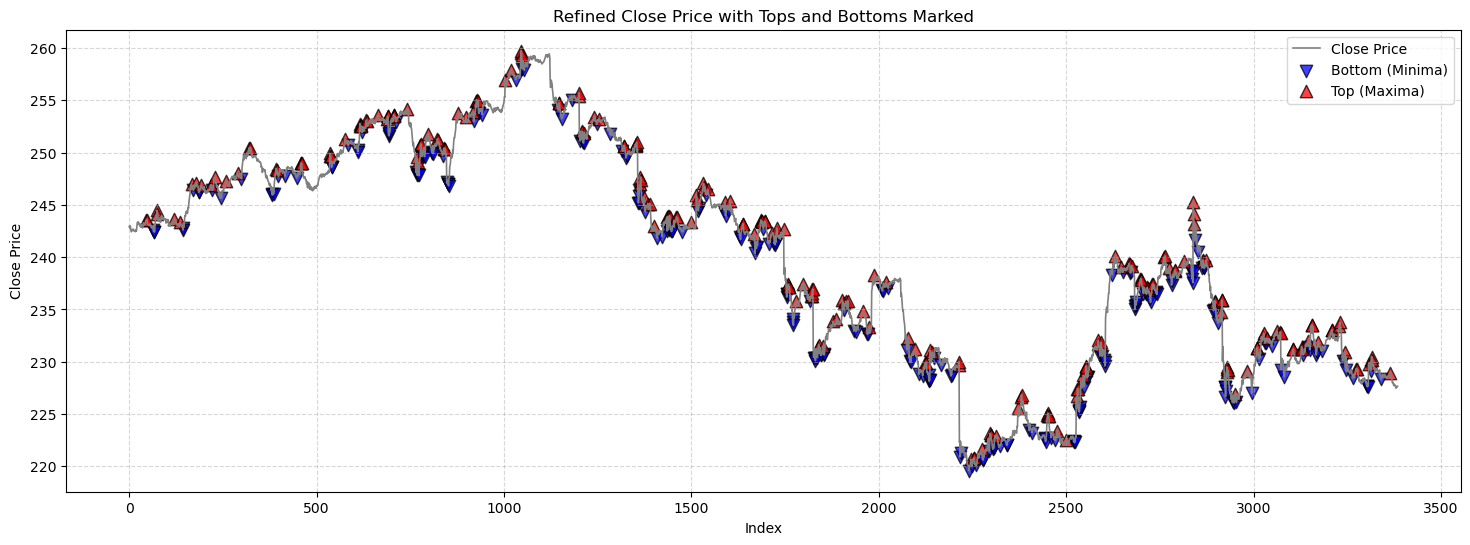

In [9]:
# Ensure the correct columns are selected
closed_prices = df['Close']  # Column name for closing prices
datetime = df['Datetime']  # Column name for timestamps

# Detect market tops and bottoms
df_top_bottom_points = top_bottom_point_marker(closed_prices, datetime, smoothing=0.25, window_size=13)


In [10]:
df_top_bottom_points

,Datetime,Close_Price,Target_Value
0,2024-12-05 15:25:00,242.929993,0
1,2024-12-05 15:30:00,242.789993,0
2,2024-12-05 15:35:00,242.997101,0
3,2024-12-05 15:40:00,242.919998,0
4,2024-12-05 15:45:00,242.610992,0
...,...,...,...
3380,2025-02-10 20:35:00,227.469894,0
3381,2025-02-10 20:40:00,227.481995,0
3382,2025-02-10 20:45:00,227.619995,0
3383,2025-02-10 20:50:00,227.679901,0


In [11]:
class_counts = df_top_bottom_points['Target_Value'].value_counts()
print(class_counts)

Target_Value
0    2927
2     232
1     226
Name: count, dtype: int64


In [13]:
turning_points_labeled_file_path = os.path.join(output_folder_feat_eng, "AAPL_turning_points_marked.csv")
df_top_bottom_points.to_csv(turning_points_labeled_file_path, index=False)